# **Table of Contents**

[Introduction](#Intro)

[Load Data and Modules](#Loading)

[Review Data](#Review_Data)

[Correlations](#Correlations)

[Prepare for Regression](#Prepare)

[Regression Selection](#Regression)

[Random Forest Regression](#Random)

[Visualizations](#Viz)

[Feature Importance](#Features)

[Predictions](#Predict)

[Results](#Results)

[Questions](#Questions)

# **Introduction** <a id="Intro"></a>

In this project, I will be predicting the cost of used cars based on the Car Pricing dataset found here: https://www.kaggle.com/datasets/sukhmandeepsinghbrar/car-price-prediction-dataset. This dataset has over 8,000 entries with a mixture of 12 numeric and categorical variables. To complete this project, I will use a pipeline to scale numerical data and create dummies from categorical data. By the end of the project, a user will be able to enter their desired data points for a used car they're interested in and receive an estimated selling price for that car.

# **Load Data and Modules** <a id="Loading"></a>

In [1]:
# Import needed modules.
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set directory and load data.
os.chdir('C:/Users/hadle/Downloads/')
df = pd.read_csv('cardekho.csv')

# Check for accuracy
current_shape = df.shape
print(f"The current shape of the dataframe is {current_shape}.")
df.head(5)

The current shape of the dataframe is (8127, 12).


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


# **Review and Clean Data** <a id="Review_Data"></a>

Review the data type for each column so I have a better understanding of the data and what manipulations I can perform.

In [3]:
# Find the data type for each column.
df.dtypes

name                   object
year                    int64
selling_price           int64
km_driven               int64
fuel                   object
seller_type            object
transmission           object
owner                  object
mileage(km/ltr/kg)    float64
engine                float64
max_power              object
seats                 float64
dtype: object

In [4]:
# It's odd that max power is listed as an object instead of a float.
# Based on an error I received, it appears that there is an entry of ' ' in the max_power column.
# Review all rows with a ' ' in the max_power col.
blank_max_power = df[df['max_power'] == ' ']
blank_max_power

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
4932,Maruti Omni CNG,2000,80000,100000,CNG,Individual,Manual,Second Owner,10.9,796.0,,8.0


In [5]:
# There is only one row with a ' ' in the max_power column.
# I can drop this column and not lose a lot of data.
df = df[df['max_power'] != ' ']

In [6]:
# I can now convert the max_power column from an object to a float.
df['max_power'] = df['max_power'].astype(float)

------------------------------------------------------------
Determine if the name column is a unique identifier.

In [7]:
# Determine how many unique entries are in the name column.
# I'm attempting to determine if this is a unique identifier for each row.
unique_name = df['name'].nunique()
unique_name

2056

In [8]:
# It appears that the name column is not a unique identifier.
# The first word of each entry in this column looks to be the "make" of the car.
# I will split the name column and assign the first word of this column to be an
# entry in the newly created "make" column.
df['make'] = df['name'].str.split().str[0]

# Check for accuracy
print(f"The previous shape of the dataframe was {current_shape}.")
current_shape = df.shape
print(f"The current shape of the dataframe is {current_shape}.")
df.head(5)

The previous shape of the dataframe was (8127, 12).
The current shape of the dataframe is (8126, 13).


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,make
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,Maruti
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,Skoda
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0,Honda
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0,Hyundai
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0,Maruti


In [9]:
# I will now drop the name column.
df.drop(columns=["name"], inplace=True)

# Check for accuracy
print(f"The previous shape of the dataframe was {current_shape}.")
current_shape = df.shape
print(f"The current shape of the dataframe is {current_shape}.")
df.head(5)

The previous shape of the dataframe was (8126, 13).
The current shape of the dataframe is (8126, 12).


,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,make
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,Maruti
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,Skoda
2,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0,Honda
3,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0,Hyundai
4,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0,Maruti


------------------------------------------------------------
Create histograms of each col to review for outliers.

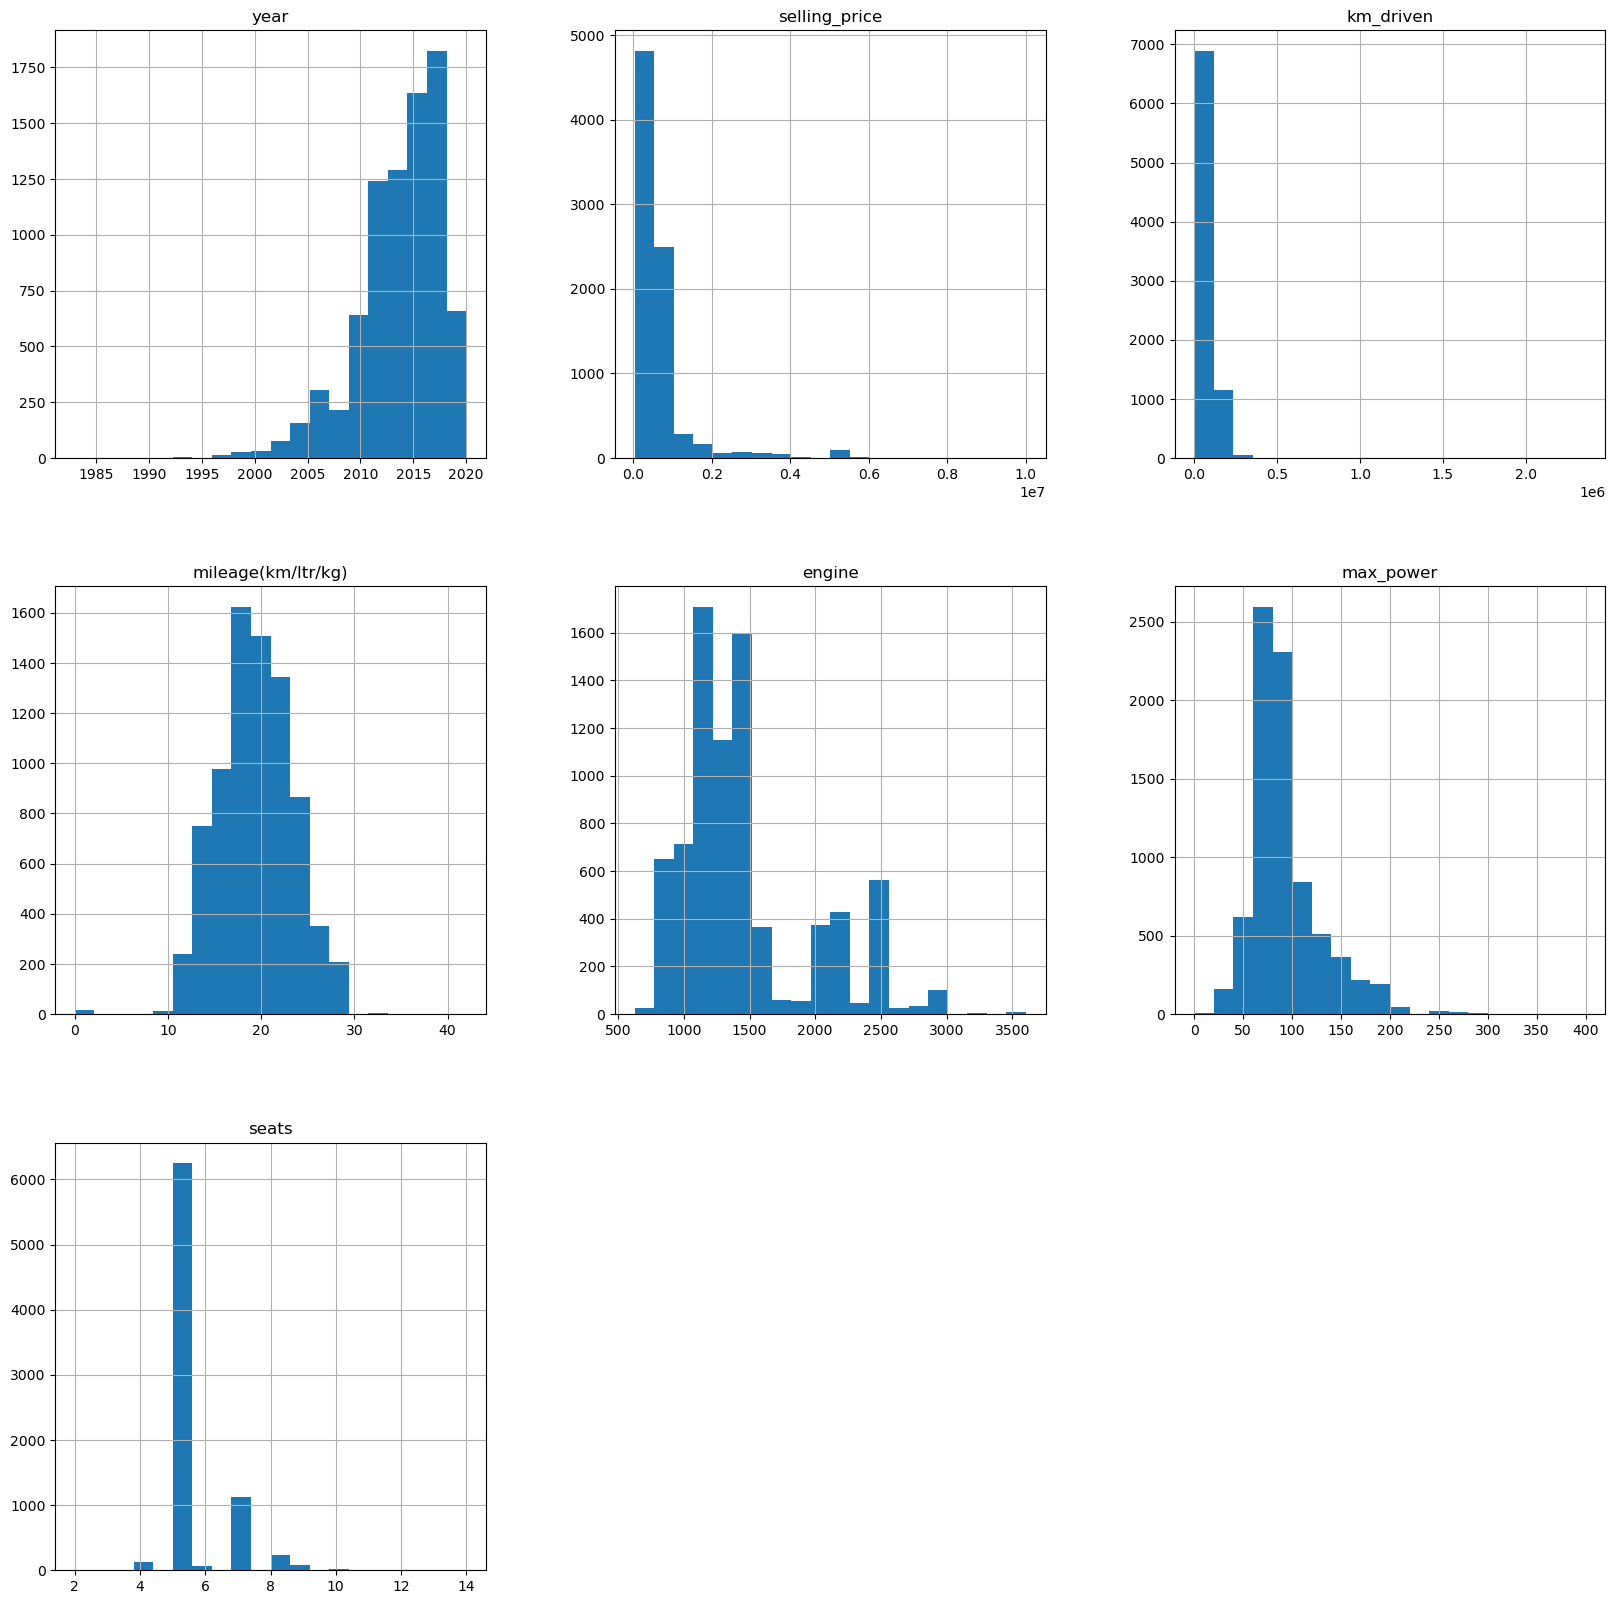

In [10]:
# Create histogram for every col in the data frame.
# Set bin size to 20 and increase the figure size for ease of viewing.
# Include ';' so only the graphs are displayed and not auxiliary data.
df.hist(bins = 20, figsize = (20,20));

------------------------------------------------------------
Review outliers.

In [11]:
# Review rows that seems appear to be outliers in the selling_price column.
# This data appears valid and not typos or incorrect data.
# This will remain in the dataframe.
high_sell_price = df[df['selling_price'] > 1000000]
high_sell_price

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,make
37,2019,1149000,5000,Petrol,Individual,Manual,First Owner,17.00,1591.0,121.30,5.0,Hyundai
41,2019,2100000,5000,Petrol,Individual,Automatic,First Owner,16.00,1368.0,160.77,5.0,Jeep
47,2014,1500000,77000,Diesel,Dealer,Manual,First Owner,12.55,2982.0,168.50,7.0,Toyota
49,2014,1450000,27800,Diesel,Dealer,Automatic,Second Owner,14.80,2143.0,120.70,5.0,Mercedes-Benz
51,2013,1090000,151000,Diesel,Dealer,Manual,First Owner,13.50,2477.0,175.56,7.0,Mitsubishi
...,...,...,...,...,...,...,...,...,...,...,...,...
7987,2019,1025000,32000,Diesel,Individual,Manual,First Owner,28.09,1248.0,88.50,5.0,Maruti
8022,2011,1200000,62000,Diesel,Individual,Automatic,Second Owner,11.72,2199.0,194.30,7.0,Hyundai
8057,2017,1689999,8000,Petrol,Dealer,Automatic,First Owner,16.60,1798.0,177.50,5.0,Audi
8058,2018,1175000,14000,Petrol,Dealer,Manual,First Owner,15.80,1591.0,121.30,5.0,Hyundai


In [12]:
# Review rows that seems appear to be outliers in the high_km_driven column.
# This data appears valid and not typos or incorrect data.
# This will remain in the dataframe.
high_km_driven = df[df['km_driven'] > 100000]
high_km_driven

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,make
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,Maruti
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,Skoda
2,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0,Honda
3,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0,Hyundai
4,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0,Maruti
...,...,...,...,...,...,...,...,...,...,...,...,...
8114,1997,40000,120000,Petrol,Individual,Manual,First Owner,16.10,796.0,37.00,4.0,Maruti
8119,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086.0,62.10,5.0,Hyundai
8122,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197.0,82.85,5.0,Hyundai
8123,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493.0,110.00,5.0,Hyundai


In [13]:
# Review rows that seems appear to be outliers in the high_max_power column.
# This data appears valid and not typos or incorrect data.
# This will remain in the dataframe.
high_max_power = df[df['max_power'] > 200]
high_max_power

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,make
132,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37,2487.0,214.56,5.0,Lexus
134,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.50,3604.0,280.00,5.0,Jeep
136,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987.0,254.79,5.0,Mercedes-Benz
141,2016,2700000,35000,Diesel,Dealer,Automatic,First Owner,15.00,2143.0,204.00,5.0,Mercedes-Benz
146,2015,2650000,53000,Diesel,Dealer,Automatic,First Owner,12.07,2967.0,241.40,7.0,Audi
...,...,...,...,...,...,...,...,...,...,...,...,...
7712,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.50,2987.0,254.79,5.0,Mercedes-Benz
7774,2014,1850000,76131,Diesel,Individual,Automatic,First Owner,13.22,2967.0,241.40,5.0,Audi
7807,2014,2575000,70000,Diesel,Individual,Automatic,First Owner,11.74,2987.0,254.80,5.0,Mercedes-Benz
7858,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37,2487.0,214.56,5.0,Lexus


------------------------------------------------------------
Determine if there are any nulls in the dataset that need to be addressed.

In [14]:
# Find the number of nulls that each column holds.
df.isnull().sum()

year                    0
selling_price           0
km_driven               0
fuel                    0
seller_type             0
transmission            0
owner                   0
mileage(km/ltr/kg)    221
engine                221
max_power             215
seats                 221
make                    0
dtype: int64

In [15]:
# Drop all rows with null values.
# Due to the spread of the variables, it doesn't make sense to replace the nulls with 0, mean, or median.
# Since it's 221 entries in a dataframe of over 8,000, I will drop these entries.  
# I will still have enough data to train a valid model.
df.dropna(inplace=True)

# Check for accuracy
print(f"The previous shape of the dataframe was {current_shape}.")
current_shape = df.shape
print(f"The current shape of the dataframe is {current_shape}.")

The previous shape of the dataframe was (8126, 12).
The current shape of the dataframe is (7905, 12).


_________________
Review distribution of categorical columns.

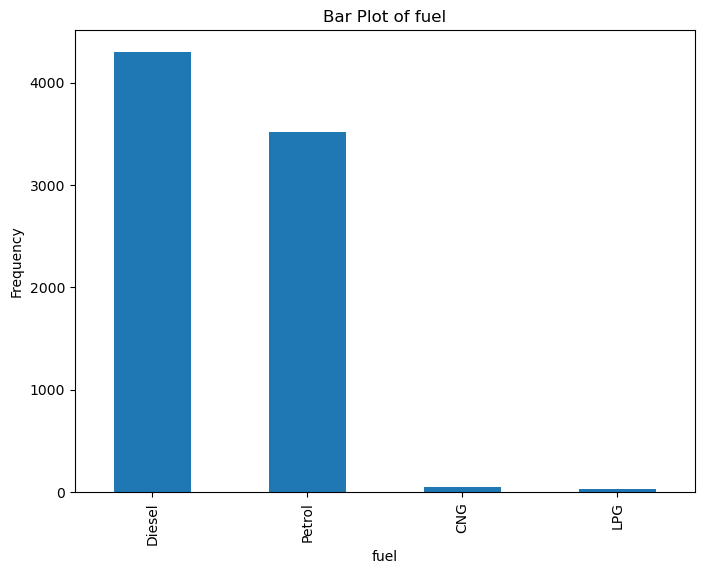

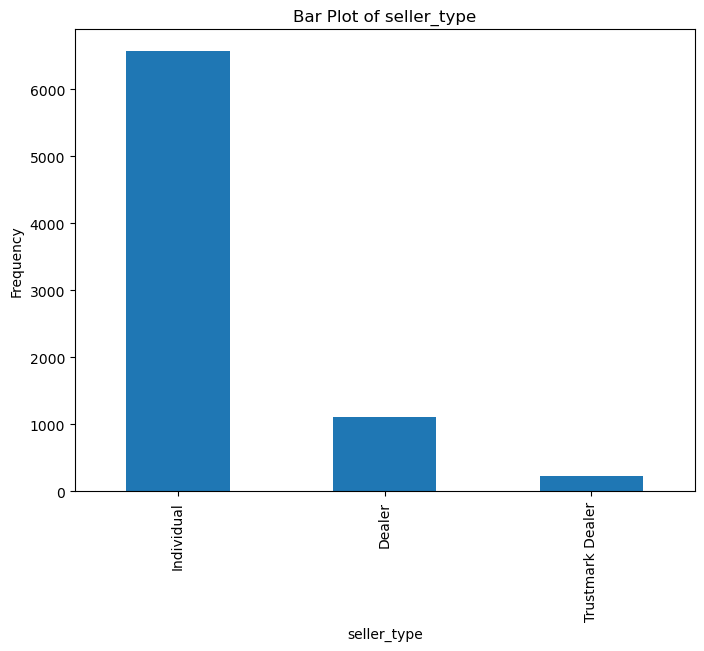

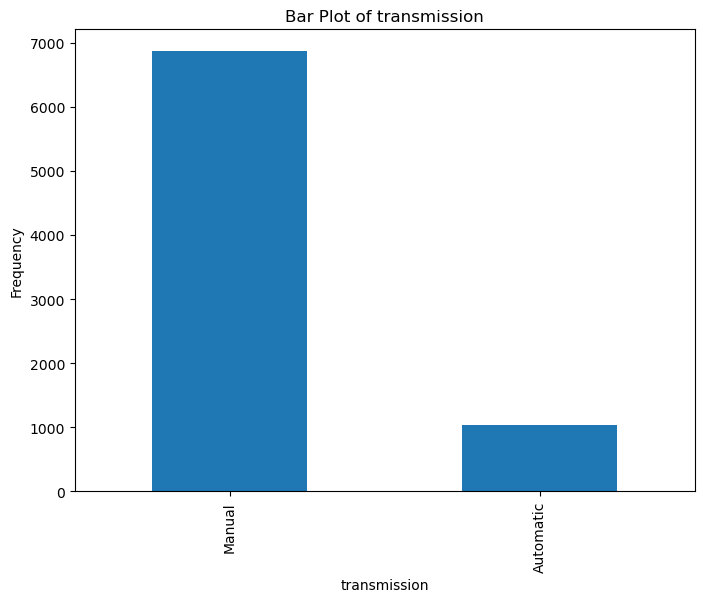

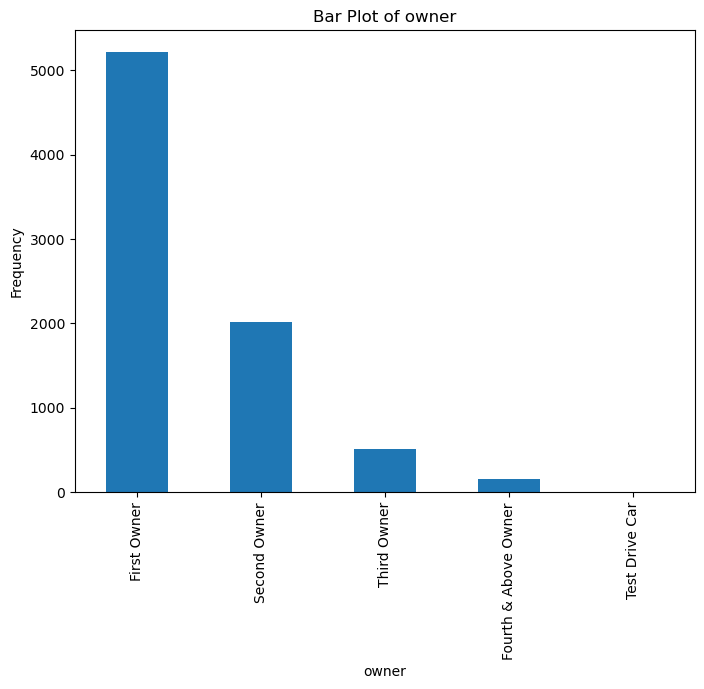

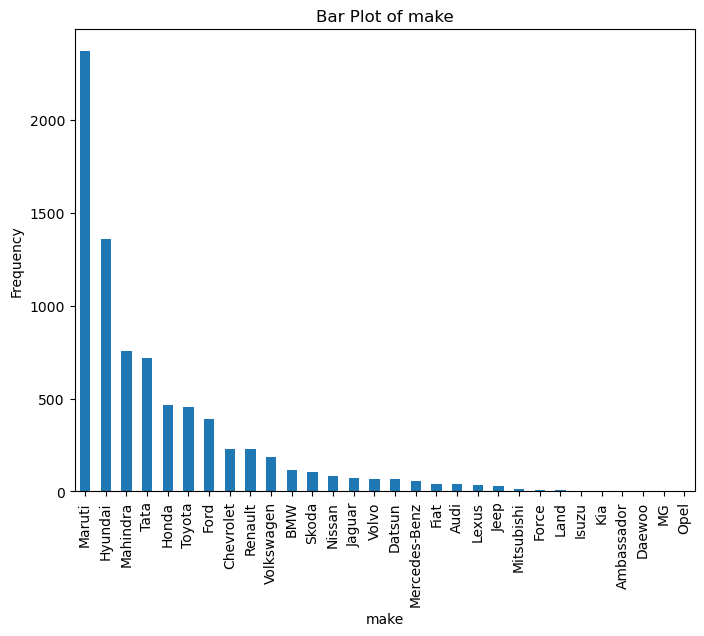

In [16]:
# Isolate categorical columns.
categorical_columns = df.select_dtypes(include='object')

# Use loop to iterate through each categorical col.
# Count the number or each entry in each col.
# Create bar graph.
# Assign graph title and axis labels.
# Display graph.
for col in categorical_columns.columns:
        categorical_columns[col].value_counts().plot(kind='bar', figsize=(8, 6))
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Bar Plot of {col}')
        plt.show()

In [17]:
# I noticed in the above that the "seller_type" column has entries for dealers and for trustmark dealers.
# There are only a few trustmark dealers, which are dealers that has extra certifications.
# I will designate all trustmark dealers as dealers.
df['seller_type'] = df['seller_type'].replace('Trustmark Dealer', 'Dealer')

# **Correlations** <a id="Correlations"></a>

I will create a correlation heatmap to note the variables that are strongly (both positively and negatively) correlated with sale price.

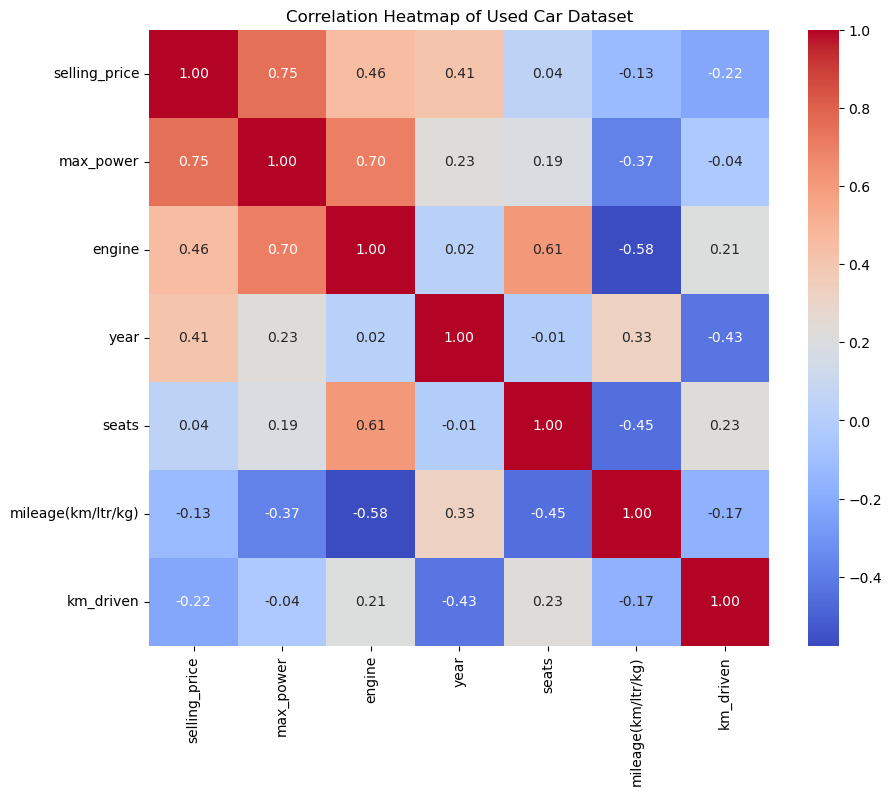

In [18]:
# Create a correlation matrix of entire data frame.
# Sort the correlation matrix based on the other numeric variables' correlations.
# with the selling_price variable.
sale_price_corr = df.corr()['selling_price'].sort_values(ascending=False)

# Convert the indices (variable names) of the above
# sale_price_corr series to a list.
# Sort (reindex) the original df based on the order of the sale_price_corr indices.
# (which were sorted based on correlation with selling_price variable above).
viz_corr_df = df.reindex(columns=sale_price_corr.index.tolist())

# Create a heatmap of the other variables' correlations
# with the selling_price variable.
# Increase figure size for ease of viewing.
# Display correlation values in heat map by including annotations.
# Round correlations to the second decimal.
# Otherwise the annotations overlap and are illegible.
# Add a color palette so high correlations are red and lower correlations are blue.
# Assign graph title.
# Display graph.
plt.figure(figsize=(10, 8))
sns.heatmap(viz_corr_df.corr(), annot=True,  fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Used Car Dataset")
plt.show()

Max_power has a strong positive correlation with selling_price at .75 indicating that max_power and selling_price tend to move together. As max_power increases, selling_price will increase as well and vice versa when the variables decrease. Conversely, km_driven has a -.22 correlation with selling_price. This is a weaker negative correlation, indicating that as km_driven decreases selling_price will increase and vice versa.

# **Prepare for Regression** <a id="Prepare"></a>

In [19]:
# Assign feature and target variables.
features = df.drop(['selling_price'], axis=1)
target = df['selling_price']

In [20]:
# Numeric and categorical features will be handled differently in the pipeline.
# Assign separate variables to hold the numeric and categorical features.
num_feat = features.select_dtypes(include=['float64', 'int64']).columns
cat_feat = features.select_dtypes(include=['object']).columns

In [21]:
# Because the numeric columns represent multiple units of measurement, they will be put through a StandardScaler.
# A standard scaler was chosen instead of a min/max scaler due to the skewed distribution of the data.
num_transform = Pipeline(steps=[('scaler', StandardScaler())])

# Dummy variables will be created for the categorical columns.
cat_transform = Pipeline(steps=[('onehot', OneHotEncoder())])

# Transform the numerical and categorical columns using the above pipelines.
transformations = ColumnTransformer(
    transformers=[('num', num_transform, num_feat),
        ('cat', cat_transform, cat_feat)])

In [22]:
# Visualize what happens when the columns are transformed.
transformations

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['year', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'max_power',
       'seats'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 Index(['fuel', 'seller_type', 'transmission', 'owner', 'make'], dtype='object'))])

In [23]:
# Split the variables into training and test sets using an 80/20 split
# and a random state of 42 for continuity.
features_train, features_test, target_train, target_test = \
    train_test_split(features, target, train_size=0.8, test_size=0.2,
                     random_state=42)

# **Regression Selection** <a id="Regression"></a>

Run the data through a loop of several regression models to determine the best fitting model based on RMSE and R-Squared value.

In [24]:
# Determine best model for data.
# Store model names and instance of models in tuple variable.
# Use random state = 42 for consistency when re-running the models.
models=[("LinearRegression",LinearRegression()), 
        ("LassoRegression",Lasso(random_state=42)), 
        ("RidgeRegression",Ridge(random_state=42)), 
        ("ElasticNet", ElasticNet(random_state=42)),
        ("K-NearestNeighbors",KNeighborsClassifier()), 
        ("DecisionTree",DecisionTreeRegressor(random_state=42)), 
        ("RandomForest",RandomForestRegressor(random_state=42))]

In [25]:
# Initiate loop which iterates through each of the above models.
# Create a pipeline which transforms the data and then runs it through each model.
# Fit the models on training variables.
# Make predictions based on features_test variable.
# Print model name and metrics.
for name, model in models:
    pipeline = Pipeline(steps=[
        ('transform', transformations),
        ('model', model)])
    pipeline.fit(features_train, target_train)
    predictions = pipeline.predict(features_test)
    print(f'Model: {name}')
    print(f'RMSE: {np.sqrt(mean_squared_error(target_test,predictions))}')
    print(f'R-Squared: {r2_score(target_test,predictions)}\n')

Model: LinearRegression
RMSE: 284564.5074873714
R-Squared: 0.8727125125337928

Model: LassoRegression
RMSE: 284564.80951976834
R-Squared: 0.8727122423316817

Model: RidgeRegression
RMSE: 284088.2233130155
R-Squared: 0.8731382457459377

Model: ElasticNet
RMSE: 476892.8945266457
R-Squared: 0.6425083070367441

Model: K-NearestNeighbors
RMSE: 227607.98027641137
R-Squared: 0.9185672275180344

Model: DecisionTree
RMSE: 149342.45225538558
R-Squared: 0.9649417036540151

Model: RandomForest
RMSE: 102669.7271231158
R-Squared: 0.9834305128474021



Based on the above metrics, the Random Forest regression model appears to be the best fits for this data. This model has an R2 value of .9834 meaning that 98.34% of the variance in selling price (target variable) can be explained by the model. This model also shows the lowest RMSE values which indicates a smaller average range of errors. I will move forward with a Random Forest regression model.

# **Random Forest Regression** <a id="Random"></a>

In [26]:
# Initialize the Random Forest Regression model outside of the loop.
rfr_model = RandomForestRegressor(random_state=42)

# Create a pipeline for the Random Forest model outside of the loop.
rfr_pipeline = Pipeline(steps=[('transform', transformations),('model', rfr_model)])

# Fit the Random Forest model on the training data.
rfr_pipeline.fit(features_train, target_train)

# Make predictions using the trained Random Forest model.
predictions_rfr = rfr_pipeline.predict(features_test)

In [27]:
# Calculate and assign variable to metrics.
RMSE = np.sqrt(mean_squared_error(target_test, predictions_rfr))
RSquared = r2_score(target_test, predictions_rfr)

# Print model name and metrics.
print("Model: Random Forest Regression")
print("RMSE:", RMSE)
print("R-Squared:", RSquared)

Model: Random Forest Regression
RMSE: 102669.7271231158
R-Squared: 0.9834305128474021


# **Visualizations** <a id="Viz"></a>

**Regression Plot -** The below regression plot graphs the predicted sales prices vs the actual sales prices. The plots gather around the red target line indicating a high rate of accuracy.

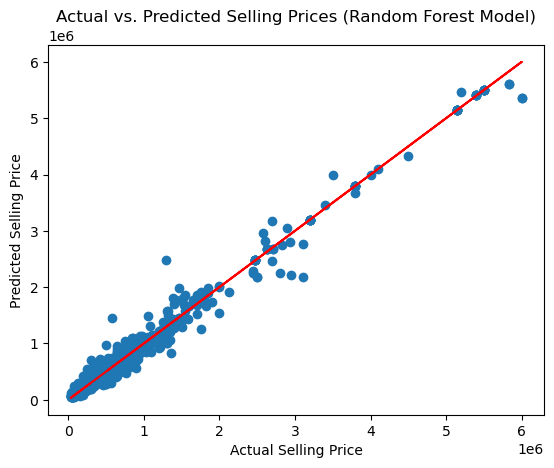

In [28]:
# Create regression plot and target line for Random Forest model.
# Assign chart title and axis labels.
# Display graph.
plt.scatter(target_test, predictions_rfr)
plt.plot(target_test, target_test, color='red')
plt.title('Actual vs. Predicted Selling Prices (Random Forest Model)')
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.show()

**Residual Plot -** The below residual plot graphs the residual amounts (the differences between the actual sales prices and the predicted sale prices) vs the values predicted by the model. The plots gather around the y-axis base line of "0" indicating a low variance between the actual values and the predicted values.

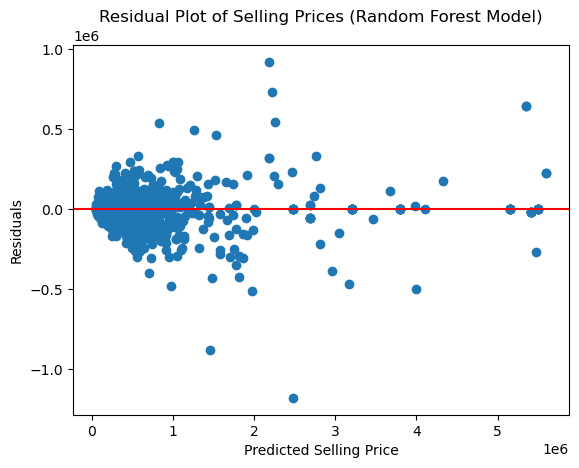

In [29]:
# Create residual plot and base line for Random Forest model.
# Assign chart title and axis labels.
# Display graph.
plt.scatter(predictions_rfr, target_test - predictions_rfr)
plt.axhline(y=0, color='red')
plt.title('Residual Plot of Selling Prices (Random Forest Model)')
plt.xlabel('Predicted Selling Price')
plt.ylabel('Residuals')
plt.show()

# **Feature Importance** <a id="Features"></a>

In [30]:
# Get the importance of each feature to the random forest model.
feat_import = rfr_model.feature_importances_

# Get a record of the feature names by getting the name of the cols
# in the original df minus the target variable.
feat_names = df.drop(['selling_price'], axis=1).columns

# Zip (partner) each feature name with its importance score
# and store in a dictionary.
feat_impact = dict(zip(feat_names, feat_import))

# Sort feat_impact in descending order by the by the 2nd element
# in each paring (importance score).
feat_impact = sorted(feat_impact.items(), key=lambda x: x[1], reverse=True)

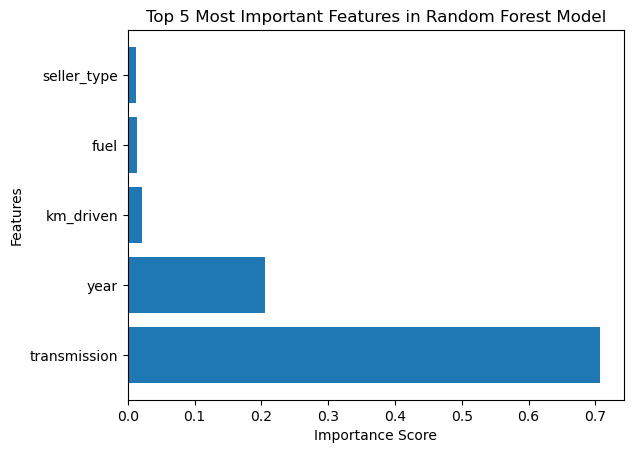

In [31]:
# Extract features and their importances from feat_impact
# and make separate list for both
# so they can each be graphed on their own axis.
feat_list = [item[0] for item in feat_impact]
import_list = [item[1] for item in feat_impact]

# Isolate the 5 features with the most importance.
top_feat_list = feat_list[:5]
top_import_list = import_list[:5]

# Create bar graph showing each feature
# and their importance in the random forest model.
# Graph feat_list on y-axis and import_list on x-axis.
# Assign graph title and axis labels.
# Display graph.
plt.barh(top_feat_list, top_import_list)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 5 Most Important Features in Random Forest Model')
plt.show()

This shows how important each feature is when the random forest model is predicting the selling price.  The type of transmission is by far the most important feature.

# **Predictions** <a id="Predict"></a>

In [32]:
# Create predictive df with entry matching features in original df.
predict_df = pd.DataFrame({
    'year': [2014],
    'km_driven': [77215],
    'fuel': ['Diesel'],   
    'seller_type': ['Individual'],       
    'transmission': ['Manual'],
    'owner': ['Second Owner'],
    'mileage(km/ltr/kg)': [25.2],
    'engine': [1248],
    'max_power': [74],    
    'seats': [5],
    'make': ['Maruti']})

In [33]:
# Separate numeric and categorical features as they will be handled differently in the pipeline.
num_feat = predict_df.select_dtypes(include=['float64', 'int64']).columns
cat_feat = predict_df.select_dtypes(include=['object']).columns

In [34]:
# Use the pipeline and the previously trained Random Forest model to make price prediction.
prediction = pipeline.predict(predict_df)

# Print the predicted price.
print(f'Predicted cost of the used car described in predictive df : ${prediction[0]:.2f}.')

Predicted cost of the used car described in predictive df : $498693.55.


# **Results** <a id="Results"></a>

In [35]:
# Find the row in original df where 'km_driven' equals 77215.
# This row has equivalent data as the predictive df above.
og_row = df[df['km_driven'] == 77215]

# Print original and predicted sale prices. 
print(f"Original Sales Price: ${float(og_row['selling_price'])}.")
print(f"Predicted Sales Price: ${round(prediction[0], 2)}.")

# Subtract the sale price in the row of the original df with
# matching data to the predictive df
# from the predicted sale price returned by running
# the scaled predictive df through the Random Forest model.
difference = (prediction[0]) - (og_row['selling_price'])

# Print the predicted house price returned by the Random Forest model.
# Convert the difference variable from a series to float
# so I can print the rounded result.
print(f'\nDifference between original sales price and predicted sale price:', end='')
print(f'${float(difference):.2f}.')
print(f"This falls within the RMSE value of ${RMSE:.2f}.")

# Calculate, isolate, and print the variance percentage.
variance = ((prediction[0] - og_row['selling_price'])/og_row['selling_price'])*100
variance = variance.iloc[0]
print(f"\nThis is a {variance:.2f}% variance from the original sales price.")

Original Sales Price: $495000.0.
Predicted Sales Price: $498693.55.

Difference between original sales price and predicted sale price:$3693.55.
This falls within the RMSE value of $102669.73.

This is a 0.75% variance from the original sales price.


# **Questions** <a id="Questions"></a>

<span style="font-size: 15px; font-weight: bold;">Question #1: Is there a way to increase the model’s accuracy?</span><a id="Q1"></a>

In my initial ideation of this project, I used a grid search to find the best hyperparameters for the Random Forest model. The grid search took extensive amounts of time and tied up much of my computer’s memory which slowed down processing. When the hyperparameters were returned I used them to retrain my model and the R-Squared value only increased by .001 indicating that they hypertuned model which paused all other processing on my computer for a great length of time was only able to explain 1% more of the variance in selling price. I made the decision that the time taken to complete the grid search was not worth the minimally improved performance. If you choose to run this project, you can weigh the pros and cons and make a decision that is right for you regarding if you would like to hyper-tune the model to improve performance. 

<span style="font-size: 15px; font-weight: bold;">Question #2: What is the benefit of using a pipeline?</span><a id="Q1"></a>

In addition to making the code more streamlined and readable, using a pipeline makes it more efficient to repeat multiple steps. For example, my pipeline scales numerical columns and makes dummies of categorical columns. I could have added additional tasks in my pipeline such as a grid search for hyperparameters (as referenced in previous question). Rather than repeating these steps multiple times, I just had to pass my data through the pipeline when selecting my data via my loop, when creating an instance of my model outside of the loop, and when making predictions on my own dataset at the end of the project. This makes the code “cleaner” than constantly repeating the same steps or introducing additional variables into the code. 

<span style="font-size: 15px; font-weight: bold;">Question #3: What if I only know some of the variables in my predictive dataframe?</span><a id="Q1"></a>

There are two options to accommodate this. The option I would suggest is that you enter the missing data to the best of your ability. For example, if you are unsure what kind of transmission you are looking for, take your best guess of the transmission that you are leaning towards. Another way to rectify this with the predictive dataframe is to make two entries: one with an automatic transmission and one with a manual transmission. 

The other option is to remove the transmission column from the original features variable and retrain the model. However, this will be more time consuming, and the loss of training variables will likely result in lower efficiency in the model. 

<span style="font-size: 15px; font-weight: bold;">Question #4: This data has a variable titled km_drive, I would like to review this variable in terms of miles.</span><a id="Q1"></a>

This can be done by creating a new column which multiples the km_driven column by 0.621371 to convert it to miles and changing the name of the column to mi_driven. Once the mi_driven column has been created, I would suggest dropping the km_driven column to prevent multicollinearity.  

The mileage(km/ltr/kg) column is also measured in km. If the km_driven column is converted to miles I would recommend also changing the mileage(km/ltr/kg) column to miles so your distance units are consistent across the dataset. 

<span style="font-size: 15px; font-weight: bold;">Question #5: I want a general idea of how much a used car costs so I understand the volume of money that is involved.</span><a id="Q1"></a>

The cost of a car varies based on different variables, but below are the overall stats from this dataset. Bear in mind that the unit of currency for this dataset is unknown. If this project is run using a dataset of your local use cars, you will know the unit of currency. 

In [36]:
# Calculate minimum selling price.
min_price = df['selling_price'].min()

# Calculate maximum selling price.
max_price = df['selling_price'].max()

# Calculate mean selling price.
mean_price = df['selling_price'].mean()

# Calculate median selling price.
median_price = df['selling_price'].median()

# Print the results with comma formatting and rounded to 2 decimal places.
# I have not included a dollar sign in the results as the unit of currency is unknown.
print("Minimum Selling Price: {:,.2f}".format(min_price))
print("Maximum Selling Price: {:,.2f}".format(max_price))
print("Mean Selling Price: {:,.2f}".format(mean_price))
print("Median Selling Price: {:,.2f}".format(median_price))

Minimum Selling Price: 29,999.00
Maximum Selling Price: 10,000,000.00
Mean Selling Price: 649,857.97
Median Selling Price: 450,000.00


<span style="font-size: 15px; font-weight: bold;">Question #6: There is a huge difference between the min and max values! Can I see the details for the cars with the min and max values so I can understand the wide spread in selling price?</span><a id="Q1"></a>

You can see below that the car with the minimum selling price is much older, has many more kms driven, is a manual transmission, and on its third owner. Additionally, the minimum price car has much lower mileage and engine power than the maximum priced car. 

In [37]:
# Locate the row with the min selling price.
id_min_price = df['selling_price'].idxmin()

# Locate the row with the max selling price.
id_max_price = df['selling_price'].idxmax()

# Print the data associated with the requested rows.
print("Row with the minimum selling price:")
print(df.loc[id_min_price])

print("\nRow with the maximum selling price:")
print(df.loc[id_max_price])


Row with the minimum selling price:
year                         1997
selling_price               29999
km_driven                   80000
fuel                       Petrol
seller_type            Individual
transmission               Manual
owner                 Third Owner
mileage(km/ltr/kg)           16.1
engine                      796.0
max_power                    37.0
seats                         4.0
make                       Maruti
Name: 5713, dtype: object

Row with the maximum selling price:
year                         2017
selling_price            10000000
km_driven                   30000
fuel                       Petrol
seller_type            Individual
transmission            Automatic
owner                 First Owner
mileage(km/ltr/kg)           42.0
engine                     1969.0
max_power                   400.0
seats                         4.0
make                        Volvo
Name: 170, dtype: object


<span style="font-size: 15px; font-weight: bold;">Question #7: Transmission is by far the most important variable in the model based on the Features Importance graph. How does selling price differ between the two transmission types?</span><a id="Q1"></a>

Manual transmission has a smaller range of selling price with prices ranging from slightly above 0 to outliers close to 400,000. Most of the selling prices are below 200,000. Automatic transmissions have a larger range with outliers as high as 10,000,000. Overall, automatic transmissions are more expensive than manual transmissions. 

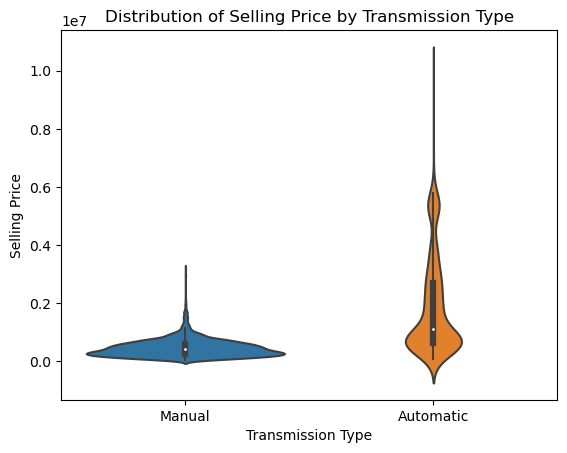

In [38]:
# Create a violin plot of selling price vs transmission.
# Assign graph title and axis labels.
# Display graph.
sns.violinplot(x='transmission', y='selling_price', data=df)
plt.title('Distribution of Selling Price by Transmission Type')
plt.xlabel('Transmission Type')
plt.ylabel('Selling Price')
plt.show()

<span style="font-size: 15px; font-weight: bold;">Question #8: How does km_driven affect selling_price?</span><a id="Q1"></a>

Km_driven is included in the top 5 most important features for the model, but it still has a low importance score. Additionally, the correlation matrix shows that km_driven has a -.22 correlation with sale price. This is not a very strong correlation, but it does show that the variables move in opposite directions (while one variable increases the other decreases.)  

The below scatterplot was created from a filtered dataframe only showing entries with km_driven less than 100,000. There are outliers with km_driven far greater than 100,000 which caused the plots to gather and be difficult to read. This scatterplot shows that for the most part, regardless of the number of kilometers driven, most cars have a selling price between 0 and 200,000. The lower km_driven cars have outliers with higher selling prices which explains the -.22 correlation. 

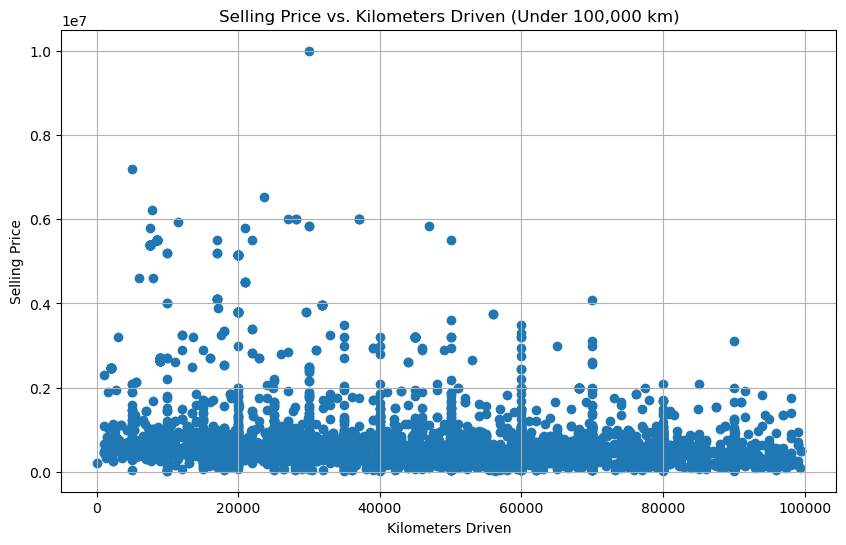

In [39]:
# Filter DataFrame for km_driven under 100,000.
filtered_km_df = df[df['km_driven'] < 100000]

# Create a scatterplot of km_driven vs selling price.
# Increase graph size for ease of viewing.
# Assign graph title and axis labels.
# Display graph.
plt.figure(figsize=(10, 6))
plt.scatter(filtered_km_df['km_driven'], filtered_km_df['selling_price'])
plt.title('Selling Price vs. Kilometers Driven (Under 100,000 km)')
plt.xlabel('Kilometers Driven')
plt.ylabel('Selling Price')
plt.grid(True)
plt.show()

<span style="font-size: 15px; font-weight: bold;">Question #9: I want a car with a powerful engine. Can I see the 10 cars with the most max_power?</span><a id="Q1"></a>

The car with the selling_price outlier also appears to be an outlier in terms of max_power. The data seems to be accurate for this entry, but a user might want to consider removing this entry prior to fitting the model due to its outlier status. 

Overall, the cars with the more powerful engines tend to be sold by first owner individuals with petrol fuel and 5 seats. 410,000 is the mode selling price for these cars. 

In [40]:
# Sort the DataFrame by "max_power" with the highest max_power entries at the top.
sorted_df = df.sort_values(by='max_power', ascending=False)

# Select the top 10 rows from the sorted dataframe.
top_powerful = sorted_df.head(10)

# Print the entries with the 10 most powerful engines.
print("Entries with the 10 most powerful engines:")
top_powerful


Entries with the 10 most powerful engines:


,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,make
170,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.00,1969.0,400.0,4.0,Volvo
148,2017,5850000,47000,Diesel,Dealer,Automatic,First Owner,13.50,2987.0,282.0,5.0,Mercedes-Benz
7702,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.50,3604.0,280.0,5.0,Jeep
5247,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.50,3604.0,280.0,5.0,Jeep
3239,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.50,3604.0,280.0,5.0,Jeep
1564,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.50,3604.0,280.0,5.0,Jeep
1860,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.50,3604.0,280.0,5.0,Jeep
134,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.50,3604.0,280.0,5.0,Jeep
5961,2009,1000000,80000,Petrol,Individual,Automatic,Third Owner,10.93,3498.0,272.0,5.0,Mercedes-Benz
5527,2014,2000000,51000,Diesel,Individual,Automatic,First Owner,14.74,2993.0,270.9,5.0,Jaguar


<span style="font-size: 15px; font-weight: bold;">Question #10: How does seller_type affect selling_price?</span><a id="Q1"></a>

Both Individual sellers and Dealers have roughly the same median selling price with the Dealer’s median just slightly higher than the Individual’s selling price. Individuals have a wider range of selling prices and many outliers indicating that there is not as much consistency in how these cars are priced. Dealer prices have more consistency, but the box (interquartile) and upper whisker show that higher prices are more common when purchasing from a dealer. 

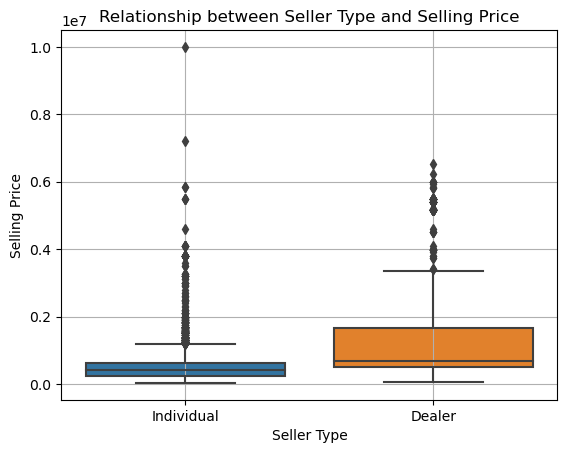

In [41]:
# Create a boxplot of seller type vs selling price.
# Assign graph title and axis labels.
# Display graph.
sns.boxplot(x='seller_type', y='selling_price', data=df)
plt.title('Relationship between Seller Type and Selling Price')
plt.xlabel('Seller Type')
plt.ylabel('Selling Price')
plt.grid(True)
plt.show()